<a href="https://colab.research.google.com/github/amalvarezme/AprendizajeMaquina/blob/main/7_TopicosAvanzados/Mnist_CAMs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install Keras-vis toolbox




In [18]:
#-------------------------------------------------------------------------------
!pip install tf-keras-vis tensorflow
#-------------------------------------------------------------------------------

# GradCAM

GradCAM is another way of visualizing attention over input. Instead of using gradients of model outputs, it uses of penultimate layer output (that is the convolutional layer just before Dense layers).

**Gradient-weighted Class Activation Mapping**. In order to obtain the class-discriminative localization map GradCAM $$L^c_{Grad-Cam}\in\mathbb{R}^{u\times v}$$
In general architectures, we first compute the gradient of $y^c$ with respect to feature maps $A$ of a convolutional layer, i.e. $\frac{\partial y^c}{\partial A^k_{ij}}$. These gradients flowing
back are global-average-pooled to obtain weights $\alpha^c_k$: $$\alpha^c_k=\frac{1}{Z}\sum_i\sum_j \frac{\partial y^c}{\partial A^k_{ij}}$$

 - $y^c\rightarrow$ score for each class $c$
 - This weight $\alpha^c_k$ represents a partial linearization of the deep network downstream from $A$, and captures the *importance* of feature map $k$ for a target class $c$.

Empirically, using the averaged gradient through Global Average Pooling (GAP) **is more robust to noise in the gradients and thus leads to better localizations** than other choices like taking the Global Max Pooling, as shown in the supplementary.

In general, $y^c$ need not be the class score produced by an image classification CNN, and could be any differentiable activation. As in CAM, our Grad-CAM heat-map is a weighted combination of feature maps, but we follow this by a ReLU: $$L^c_{Grad-Cam}=ReLU\left(\sum_k\alpha^c_kA^k\right)$$

* The motivation for the ReLU is the following – we are only interested in the features that have a positive influence on the class of interest, i.e. pixels whose intensity should be increased in order to increase $y^c$. Since the feature maps $A$ are already non-negative, we rectify the heat-map obtained to highlight such pixel.


## GradCam implementation per trial

# GradCAM++

GradCAM++ can provide better visual explanations of CNN model predictions.

the final classification score $Y^c$ for a particular class $c$ can be written as a linear combination of its global average pooled last convolutional layer feature maps $A^k$

$$Y^c= \sum_k w_k^c \sum_i \sum_j A_{ij}^k$$

Each spatial location $(i,j)$ in the class-specific saliency map $L_c$ is then calculated as:
$$L_{i,j}^c= \sum_k w_k^cA_{ij}^k$$
$L_{ij}^c$ directly correlates with the importance of a particular spatial location $(i,j)$ for a particular class $c$ and thus functions as a visual explanation of the class predicted by the network. CAM estimates these weights $w_k^c$ by training a linear classifier for each class c using the activations maps of the last convolutional layer generated for a given image.
This hoever limits its explainability prowess to CNNs with a GAP penultimate layer, and requires retraining of multiple linear classifiers (one for each class), after training of the initial model.

Grad-CAM was built to address these issues. This approach define weights $w_k^c$ for a particular feature map $A^k$ and class $c$ as:
$$w_k^c=\frac{1}{Z}\sum_i \sum_j \frac{\partial Y^c}{\partial A_{ij}^k} $$

Consider a saliency map $L^c$ (where $i$ and $j$ are the iterators over the pixels in the map). $A^k$ represents the visualization of the $k^{th}$ feature map. The derivate $\frac{\partial y^c}{\partial A_{ij}^k}$ is expected to be high for the feature map pixels that contribute to the presence of the object. Without loss of generality, let us asume the derivative map to be:

$$\frac{\partial y^c}{\partial A_{ij}^k}=1 \;\;\; if \;\;\; A_{ij}^k=1$$
$$\frac{\partial y^c}{\partial A_{ij}^k}=0 \;\;\; if \;\;\; A_{ij}^k=0$$

different feature maps may be activated with difering spatial footprints, and the feature maps with lesser footprints fade away in the final seliency map

This problem can be fixed by taking a weighted average of the pixel-wise gradients. In particular, we reformulate the structure of the weights $w_k^c$
$$w_k^c=\sum_i \sum_j \alpha_{ij}^{kc}relu\left (\frac{\partial Y^c}{\partial A_{ij}^k} \right)$$
where $relu$ is the rectified linear unit activation function. Here the $\alpha_{ij}^{kc}$ are the weighting co-efficients for the pixel-wise gradients for class c and convolutional feature map $A^k$. In the above example, by taking

$$\alpha_{ij}^{kc}= \frac{1}{\sum_{l,m}\frac{\partial Y^c}{\partial A_{lm}^k} }\;\;\; if \;\;\;\frac{\partial Y^c}{\partial A_{ij}^k}=1$$
$$= 0 \;\;\;  otherwise$$

# Saliency maps

`Saliency` generates a saliency map that appears the regions of ​​the input image that contributes the most to the output value.

Los mapas sobresalientes para una imagen dada, $L^c$ son calculados como una combinacion lineal de los mapas de activacion, seguida por una capa relu:

$$L_{ij}^c = relu \left(\sum_k w_k^c A_{ij}^k \right)$$

Similar a Grad-CAM,

# ScoreCAM

Given a CNN model $Y = f(X)$ that takes an input $X$ and outputs a scalar $Y$. We pick an internal convolutional layer $l$ in $f$ and the corresponding activation as $A$. Denote the $k-th$ channel of $A_l$ by $A_l^k$ towards. For a known baseline input $X_b$, the contribution $A_l^k$ towards $Y$ is defined as
$$C(A_l^k)=f(X\circ H_l^k)-f(X_b)$$
where
$$H_l^k = s(Up(A_l^k))$$
$Up(\cdot)$ denotes the operation that upsamples $A_l^k$ into the input size and $s(\cdot)$ is a normalization function that maps each element in the input matrix into $[0,1]$

- Use of Upsampling

# Supporting modules

In [19]:
#-------------------------------------------------------------------------------
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
import tensorflow as tf
import pickle
from tf_keras_vis.utils.scores import CategoricalScore
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
from matplotlib import cm
from tf_keras_vis.gradcam import Gradcam
from sklearn.model_selection import ShuffleSplit
from tensorflow import keras
from tensorflow.keras.constraints import max_norm
from tensorflow.keras import backend as K
from tf_keras_vis.saliency import Saliency
from tf_keras_vis.scorecam import Scorecam
from tf_keras_vis.gradcam_plus_plus import GradcamPlusPlus
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
#-------------------------------------------------------------------------------

# Data loading and normalization

In [20]:
#cargar fashion mnist o mnist
#(X_train, y_train), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
X_train, X_valid = X_train[:-55000], X_train[-55000:]
y_train, y_valid = y_train[:-55000], y_train[-55000:]

X_train = X_train[..., np.newaxis]/255.
X_valid = X_valid[..., np.newaxis]/255.
X_test = X_test[..., np.newaxis]/255.
print(X_train.shape,X_valid.shape,X_test.shape)

(5000, 28, 28, 1) (55000, 28, 28, 1) (10000, 28, 28, 1)


# Training Deep CNN model

In [21]:
from functools import partial
tf.keras.backend.clear_session()

DefaultConv2D = partial(tf.keras.layers.Conv2D,
                        kernel_size=3, activation='relu', padding="SAME")

tf.keras.backend.clear_session()
inputA= tf.keras.layers.Input(shape=(X_train.shape[1],X_train.shape[2],X_train.shape[3]), name='input')
tmp = tf.keras.layers.BatchNormalization()(inputA)
tmp = DefaultConv2D(filters=16, kernel_size=7,name='cnn_0')(inputA)
tmp = tf.keras.layers.BatchNormalization()(tmp)
tmp = tf.keras.layers.MaxPooling2D(pool_size=2)(tmp)
tmp = tf.keras.layers.BatchNormalization()(tmp)
tmp = DefaultConv2D(filters=32, kernel_size=3,name='cnn_1')(tmp)
tmp = tf.keras.layers.BatchNormalization()(tmp)
tmp = tf.keras.layers.MaxPooling2D(pool_size=2)(tmp)
tmp = tf.keras.layers.BatchNormalization()(tmp)
tmp = DefaultConv2D(filters=32, kernel_size=3,name='cnn_2')(tmp)
tmp = tf.keras.layers.BatchNormalization()(tmp)

tmp = tf.keras.layers.Flatten()(tmp)
tmp = tf.keras.layers.Dense(units=64, activation='relu',name='dense_0')(tmp)
tmp = tf.keras.layers.BatchNormalization()(tmp)
tmp = tf.keras.layers.Dropout(0.25)(tmp) # regularizar, apagar aleatoriamente neuronas
tmp = tf.keras.layers.Dense(units=32, activation='relu',name='dense_1')(tmp)
tmp = tf.keras.layers.BatchNormalization()(tmp)
tmp = tf.keras.layers.Dropout(0.25)(tmp)
output = tf.keras.layers.Dense(units=10, activation='softmax')(tmp)

#built model
model = tf.keras.Model(inputs=[inputA],outputs=[output])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)                   │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ cnn_0 (Conv2D)                       │ (None, 28, 28, 16)          │             800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 28, 28, 16)          │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 14, 14, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 14, 14, 16)          │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ cnn_1 (Conv2D)                       │ (None, 14, 14, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 14, 14, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 7, 7, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 7, 7, 32)            │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ cnn_2 (Conv2D)                       │ (None, 7, 7, 32)            │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 7, 7, 32)            │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1568)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_0 (Dense)                      │ (None, 64)                  │         100,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32)                  │              

 Total params: 118,410 (462.54 KB)

 Trainable params: 117,962 (460.79 KB)

 Non-trainable params: 448 (1.75 KB)

In [22]:
#training
model.compile(loss="sparse_categorical_crossentropy", optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.005), metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=30, validation_data=(X_valid, y_valid),batch_size=128)

Epoch 1/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 21s 287ms/step - accuracy: 0.6684 - loss: 1.1139 - val_accuracy: 0.4481 - val_loss: 1.6916
Epoch 2/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.9371 - loss: 0.2359 - val_accuracy: 0.5327 - val_loss: 1.4215
Epoch 3/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.9624 - loss: 0.1478 - val_accuracy: 0.3258 - val_loss: 2.5090
Epoch 4/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.9561 - loss: 0.1451 - val_accuracy: 0.3546 - val_loss: 2.3835
Epoch 5/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - accuracy: 0.9728 - loss: 0.1058 - val_accuracy: 0.7607 - val_loss: 0.8086
Epoch 6/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.9722 - loss: 0.0927 - val_accuracy: 0.7985 - val_loss: 0.7042
Epoch 7/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.9832 - loss: 0.0561 - val_accuracy: 0.8871 - val_loss: 0.4252
Epoch 8/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.9826 - loss: 0.0510 - val_accuracy: 0.8874 -

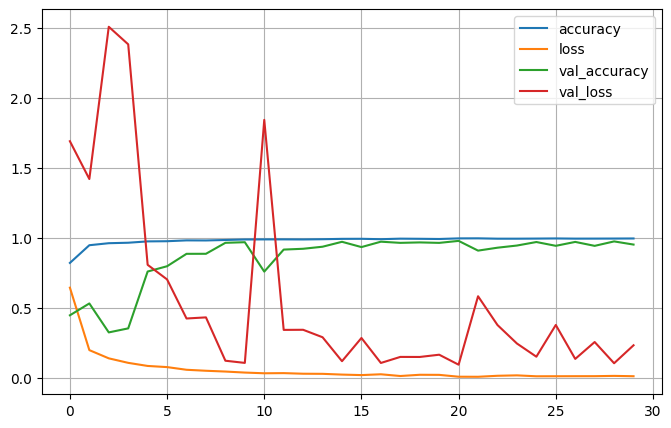

In [23]:
import pandas as pd

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.show()

In [24]:
score   = model.evaluate(X_test, y_test)
print(score)
X_new   = X_test[:5] # pretend we have new images
y_pred  = model.predict(X_new)
print(y_pred.round(2),y_test[:5])

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9495 - loss: 0.2513
[0.21618027985095978, 0.9563000202178955]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step
[[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]] [7 2 1 0 4]


# Feature maps

In [25]:
def plot_featureMaps(X,model,layer_name,n_rows=4,n_cols=4):
    model_B = tf.keras.Model(inputs=model.inputs,outputs=model.get_layer(layer_name).output) #se accede a capas por nombre
    #tf.keras.utils.plot_model(model_B) # modleo ya esta ajustado!
    z = model_B.predict(X)
    print('Shape',z.shape)
    plt.figure(figsize=(3,3))
    if X.shape[-1]==1:
        plt.imshow(X[0,:,:,0], cmap="binary", interpolation="nearest")
    else:
        plt.imshow(X[0])
    tit=str(model.predict(X).round(2))
    plt.title(tit)
    plt.axis('off')
    plt.show()

    f, ax = plt.subplots(nrows=n_rows, ncols=n_cols,figsize=(6,6))
    index = 0
    for row in range(n_rows):
        for col in range(n_cols):
            index = n_cols * row + col
            pb = ax[row,col].imshow(z[0,:,:,index], cmap="jet", interpolation="nearest",vmin=z.min(),vmax=z.max())
            ax[row,col].axis('off')
            ax[row,col].set_title("f_m" + str(index+1), fontsize=12)

    plt.tight_layout()
    cbar_ax = f.add_axes([1.01, 0, 0.025, 0.95])
    f.colorbar(pb,shrink=0.25, cax=cbar_ax)
    #save_fig('fashion_mnist_plot', tight_layout=False)
    plt.show()
    return

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
Shape (1, 28, 28, 16)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step


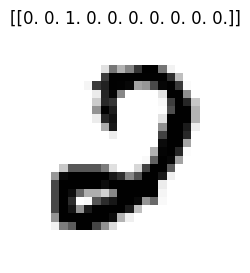

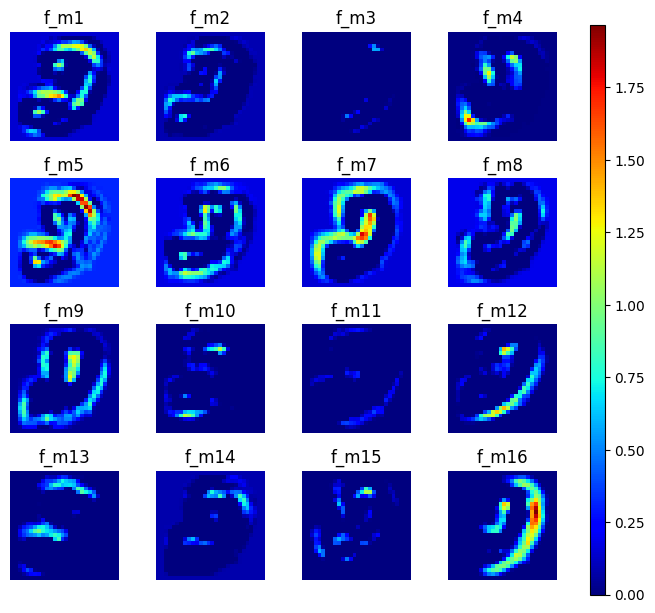

In [26]:
#plot feature maps
plot_featureMaps(X_test[400][np.newaxis,...],model,layer_name='cnn_0',n_rows=4,n_cols=4)

# Training deep and wide cnn model

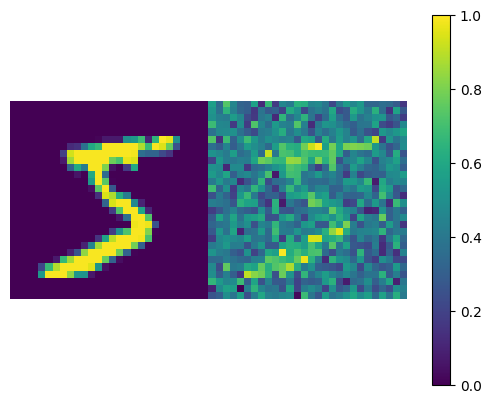

In [27]:
#creating wide inputs
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import MinMaxScaler

var_ = [0.25]
inputs_train = [X_train]
inputs_valid = [X_valid]
inputs_test = [X_test]


for var_i in var_:
    dim = X_train.shape
    tmp = X_train + (np.sqrt(var_i)*np.random.randn(X_train.shape[0],dim[1],dim[2],dim[3]))
    tmp = MinMaxScaler().fit_transform(tmp.reshape(dim[0],-1).T).T
    inputs_train += [tmp.reshape(dim)]

    dim = X_valid.shape
    tmp = X_valid + (np.sqrt(var_i)*np.random.randn(X_valid.shape[0],dim[1],dim[2],dim[3]))
    tmp = MinMaxScaler().fit_transform(tmp.reshape(dim[0],-1).T).T
    inputs_valid += [tmp.reshape(dim)]

    dim = X_test.shape
    tmp = X_test + (np.sqrt(var_i)*np.random.randn(X_test.shape[0],dim[1],dim[2],dim[3]))
    tmp = MinMaxScaler().fit_transform(tmp.reshape(dim[0],-1).T).T
    inputs_test += [tmp.reshape(dim)]


plt.imshow(np.c_[inputs_train[0][0,:,:,0],inputs_train[-1][0,:,:,0]])
plt.axis('off')
plt.colorbar()
plt.show()

In [28]:
#deep and wide
tf.keras.backend.clear_session()
l1 = 1e-3
input_ = [None] * len(inputs_train)
batch0_ = [None] * len(inputs_train)
batch1_ = [None] * len(inputs_train)
batch2_ = [None] * len(inputs_train)
batch3_ = [None] * len(inputs_train)
batch4_ = [None] * len(inputs_train)
batch5_ = [None] * len(inputs_train)
batch6_ = [None] * len(inputs_train)
conv0_ = [None] * len(inputs_train)
conv1_ = [None] * len(inputs_train)
conv2_ = [None] * len(inputs_train)
pool0_ = [None] * len(inputs_train)
pool1_ = [None] * len(inputs_train)
pool2_ = [None] * len(inputs_train)
#loop
for i in range(len(inputs_train)):
    input_[i] = tf.keras.layers.Input(shape=inputs_train[i].shape[1:])
    batch0_[i] = tf.keras.layers.BatchNormalization()(input_[i])
    # ------------------------------------------------------------------------------------------------------
    conv0_[i] = tf.keras.layers.Conv2D(filters=16, kernel_size=7, strides=1, activation='relu', name = 'wcnn_0'+str(i),
                                    padding='SAME', kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1, l2=l1),
                                    kernel_initializer="GlorotNormal")(batch0_[i])
    # ------------------------------------------------------------------------------------------------------
    batch1_[i] = tf.keras.layers.BatchNormalization()(conv0_[i])
    pool0_[i] = tf.keras.layers.MaxPooling2D(pool_size=2)(batch1_[i])
    batch2_[i] = tf.keras.layers.BatchNormalization()(pool0_[i])
    # ------------------------------------------------------------------------------------------------------
    conv1_[i] = tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=1, activation='relu',name = 'wcnn_1'+str(i),
                                    padding='SAME', kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1, l2=l1),
                                    kernel_initializer="GlorotNormal")(batch2_[i])
    # ------------------------------------------------------------------------------------------------------
    batch3_[i] = tf.keras.layers.BatchNormalization()(conv1_[i])
    pool1_[i] = tf.keras.layers.MaxPooling2D(pool_size=2)(batch3_[i])
    batch4_[i] = tf.keras.layers.BatchNormalization()(pool1_[i])
    # ------------------------------------------------------------------------------------------------------
    conv2_[i] = tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=1, activation='relu', name = 'wcnn_2'+str(i),
                                    padding='SAME', kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1, l2=l1),
                                    kernel_initializer="GlorotNormal")(batch4_[i])
    # ------------------------------------------------------------------------------------------------------
    batch5_[i] = tf.keras.layers.BatchNormalization()(conv2_[i])
    pool2_[i] = tf.keras.layers.MaxPooling2D(pool_size=2)(batch5_[i])
    batch6_[i] = tf.keras.layers.BatchNormalization()(pool2_[i])
    # ------------------------------------------------------------------------------------------------------
concat = tf.keras.layers.concatenate(batch6_)
flat = tf.keras.layers.Flatten()(concat)
d0 = tf.keras.layers.Dense(units=64, activation='relu',name='dense_0',
                           kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1, l2=l1))(flat)
b0 = tf.keras.layers.BatchNormalization()(d0)
#dr = tf.keras.layers.Dropout(0.25)(b0) # regularizar, apagar aleatoriamente neuronas
d1 = tf.keras.layers.Dense(units=32, activation='relu',name='dense_1',
                           kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1, l2=l1))(b0)
b1 = tf.keras.layers.BatchNormalization()(d1)
#dr = tf.keras.layers.Dropout(0.25)(b1)
output = tf.keras.layers.Dense(units=10, activation='softmax')(b1)
#built model
model_dw = tf.keras.Model(inputs=input_,outputs=[output])

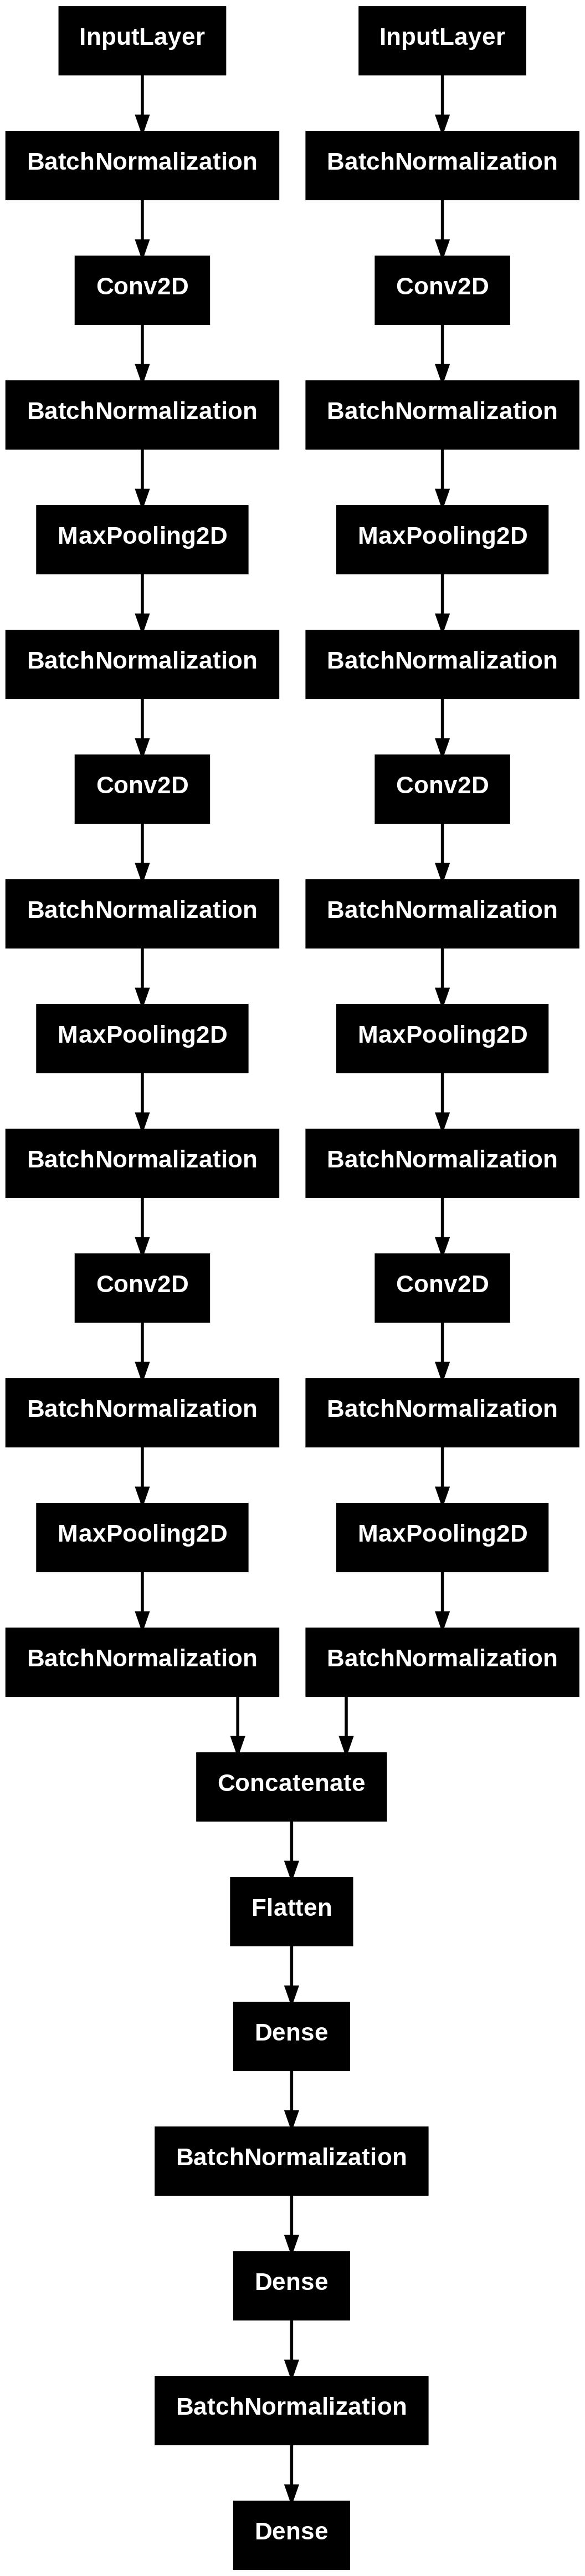

In [29]:
tf.keras.utils.plot_model(model_dw)

In [30]:
#training
model_dw.compile(loss="sparse_categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(learning_rate=0.002), metrics=["accuracy"])
history = model_dw.fit(inputs_train, y_train, epochs=30, validation_data=(inputs_valid, y_valid),batch_size=128)

Epoch 1/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 22s 238ms/step - accuracy: 0.5851 - loss: 5.0463 - val_accuracy: 0.1123 - val_loss: 5.9402
Epoch 2/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step - accuracy: 0.9623 - loss: 3.3258 - val_accuracy: 0.1123 - val_loss: 5.6511
Epoch 3/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.9802 - loss: 2.4743 - val_accuracy: 0.1123 - val_loss: 5.2239
Epoch 4/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.9842 - loss: 1.8573 - val_accuracy: 0.1123 - val_loss: 4.3751
Epoch 5/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 0.9587 - loss: 1.6426 - val_accuracy: 0.1616 - val_loss: 3.4112
Epoch 6/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.9821 - loss: 1.4295 - val_accuracy: 0.1265 - val_loss: 3.6790
Epoch 7/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.9666 - loss: 1.2889 - val_accuracy: 0.2845 - val_loss: 3.2564
Epoch 8/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9795 - loss: 1.1339 - val_accuracy: 0.3367 -

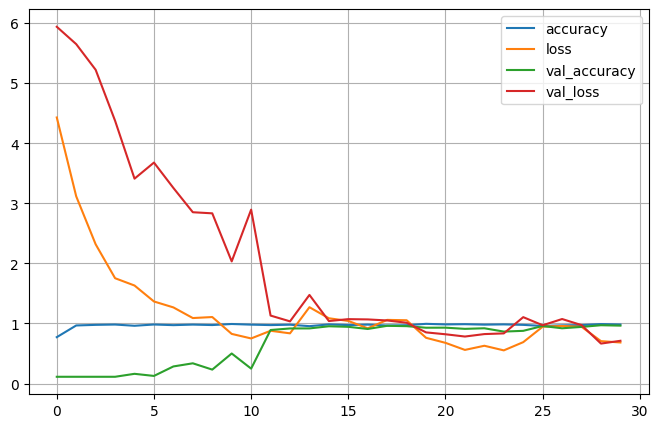

In [31]:
import pandas as pd
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.show()

In [32]:
#attention maps wide models
#attention maps
from mpl_toolkits.axes_grid1 import make_axes_locatable

def centroid_(X):
   D = pairwise_distances(X, X.mean(axis=0).reshape(1,-1))
   inertia_ = D.mean()
   return np.argmin(D),inertia_

def plot_attention(tmpr_,layer_name,list_class,figsize=(10,5), transpose=False):


    if transpose:
      x_label_list = layer_name
      nC = len(list_class)
      nl = len(layer_name)
      ncols,nrows = tmpr_.shape

      y_label_list = []
      for ii in range(nC):
          y_label_list += str(list_class[ii])

      dw = nrows/nl
      list_xticks = []
      for ii in range(nl):
        list_xticks += [int(dw*(0.5+ii))]
      dw = ncols/nC
      list_yticks = []
      for ii in range(nC):
        list_yticks += [int(dw*(0.5+ii))]

    else:
      y_label_list = layer_name
      nC = len(list_class)
      nl = len(layer_name)
      nrows,ncols = tmpr_.shape

      x_label_list = []
      for ii in range(nC):
          x_label_list += str(list_class[ii])

      dw = nrows/nl
      list_yticks = []
      for ii in range(nl):
        list_yticks += [int(dw*(0.5+ii))]
      dw = ncols/nC
      list_xticks = []
      for ii in range(nC):
        list_xticks += [int(dw*(0.5+ii))]

    plt.figure(figsize=figsize)
    ax = plt.gca()
    im = ax.imshow(tmpr_)
    im = ax.imshow(tmpr_)
    ax.set_yticks(list_yticks)
    ax.set_yticklabels(y_label_list)
    ax.set_xticks(list_xticks)
    ax.set_xticklabels(x_label_list,rotation = 'vertical') #
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)

    plt.colorbar(im, cax=cax,extend='both',
                 ticks=[np.round(tmpr_.min(),1), np.round(0.5*(tmpr_.max()-tmpr_.min()),1), np.round(tmpr_.max(),1)])
    #plt.yticks(rotation=45)


    plt.tight_layout()
    plt.show()
    return

def attention_wide(modelw,rel_model_name,layer_name,X_train,y_train,
                   normalize_cam=False,norm_max_min=False,norm_c=True,
                   plot_int=False,centroid_=False,smooth_samples=20,
                   smooth_noise=0.20,transpose=False):
    #-------------------------------------------------------------------------------
    # define trial sample to visualize
    # change activations of last layer by linear
    replace2linear = ReplaceToLinear()
    #relevance model

    if rel_model_name == 'Gradcam':
        gradcamw = Gradcam(modelw,
                        model_modifier=replace2linear,
                        clone=True)
    elif rel_model_name == 'Gradcam++':
        gradcamw = GradcamPlusPlus(modelw,
                              model_modifier=replace2linear,
                              clone=True)

    elif rel_model_name == 'Scorecam':
        scorecamw = Scorecam(modelw)

    elif rel_model_name == 'Saliency':
          saliencyw = Saliency(modelw,
                              model_modifier=replace2linear,
                              clone=True)
          layer_name = [''] #saliency doesn't depend on different layers
    nC = len(np.unique(y_train))
    relM = [None]*nC
    if type(X_train)==list:
        n_inputs = len(X_train)
        new_input = [None]*n_inputs

    for c in range(len(np.unique(y_train))):
      id_sample = y_train == np.unique(y_train)[c]

      if (type(X_train)==list) and (rel_model_name != 'Saliency'):
        relM[c] = np.zeros((sum(id_sample),X_train[0].shape[1],X_train[0].shape[2],len(layer_name)))
        #print(1,relM[c].shape)
      elif (type(X_train)==list) and (rel_model_name == 'Saliency'):
        relM[c] = np.zeros((sum(id_sample),X_train[0].shape[1],X_train[0].shape[2],len(X_train)))
        #print(2,relM[c].shape)
      else:
        relM[c] = np.zeros((sum(id_sample),X_train.shape[1],X_train.shape[2],len(layer_name)))
        #print(3,relM[c].shape)
      score = CategoricalScore(list(y_train[id_sample])) #-> [0] para probar a una clase diferente
      if type(X_train)==list:
          for ni in range(n_inputs):
              new_input[ni] = X_train[ni][id_sample]
      else:
        new_input = X_train[id_sample]
      #print('rel',rel_model_name,'layer',layer_name[l])
      for l in range(len(layer_name)):
          print(rel_model_name,'class', np.unique(y_train)[c],'layer',layer_name[l])
      # label score -> target label accoring to the database
      #-----------------------------------------------------------------------------
      # generate heatmap with GradCAM
          if (rel_model_name == 'Gradcam') or (rel_model_name == 'Gradcam++'):
              rel = gradcamw(score,
                          new_input,
                          penultimate_layer=layer_name[l], #layer to be analized
                          expand_cam=True,
                          normalize_cam=normalize_cam)
          elif rel_model_name == 'Saliency': #saliency map is too noisy, so let’s remove noise in the saliency map using SmoothGrad!
                rel = saliencyw(score, new_input,smooth_samples=smooth_samples,
                                smooth_noise=smooth_noise,normalize_map=normalize_cam) #, smooth_samples=20,smooth_noise=0.20) # The number of calculating gradients iterations.

          elif rel_model_name == 'Scorecam':
              rel = scorecamw(score, new_input, penultimate_layer=layer_name[l], #layer to be analized
                          expand_cam=True,
                          normalize_cam=normalize_cam) #max_N=10 -> faster scorecam

          #save model

          if rel_model_name != 'Saliency':
            if type(X_train)==list:
              tcc = rel[0]
            else:
              tcc = rel
            dimc = tcc.shape
            tccv = tcc.ravel()
            tccv[np.isnan(tccv)] = 0
            tcc = tccv.reshape(dimc)
            if norm_max_min: #normalizing along samples
              tcc = MinMaxScaler().fit_transform(tcc.reshape(dimc[0],-1).T).T
              tcc = tcc.reshape(dimc)
            relM[c][...,l] = tcc
            if l==0:
              tmp = np.median(relM[c][...,l],axis=0)#relM[c][...,l].mean(axis=0)
            else:
              if transpose:
                tmp = np.c_[tmp,np.median(relM[c][...,l],axis=0)]#np.r_[tmp,relM[c][...,l].mean(axis=0)]  #centroid
              else:
                tmp = np.r_[tmp,np.median(relM[c][...,l],axis=0)]#np.r_[tmp,relM[c][...,l].mean(axis=0)]  #centroid
          else: #saliency
            if type(X_train)==list:
              tcc = np.zeros((rel[0].shape[0],rel[0].shape[1],rel[0].shape[2],len(rel)))
              for ii in range(len(rel)):
                  tcc[...,ii] = rel[ii]
            else:
              tcc = rel
            dimc = tcc.shape
            tccv = tcc.ravel()
            tccv[np.isnan(tccv)] = 0
            tcc = tccv.reshape(dimc)
            if norm_max_min: #normalizing along samples
              tcc = MinMaxScaler().fit_transform(tcc.reshape(dimc[0],-1).T).T
              tcc = tcc.reshape(dimc)
            relM[c] = tcc
            if type(X_train)==list:
              tmp = np.median(tcc[...,0],axis=0)
              for ii in range(len(rel)-1):
                  if transpose:
                    tmp = np.c_[tmp,np.median(tcc[...,ii+1],axis=0)]
                  else:
                    tmp = np.r_[tmp,np.median(tcc[...,ii+1],axis=0)]
            else:
               tmp = np.median(tcc,axis=0)

      if norm_c: #normalizing along layers
        tmp = tmp/(1e-8+tmp.max())
      if c==0:
        tmpr = tmp
      else:
        if transpose:
          tmpr = np.r_[tmpr,tmp]
        else:
          tmpr = np.c_[tmpr,tmp]
      #print(tmp.shape,tmp.max())
      if plot_int: #plot every class
         plt.imshow(tmp)
         plt.colorbar(orientation='horizontal')
         plt.axis('off')
         plt.show()
    tmpr = tmpr/(1e-8+tmpr.max())
    list_class = np.unique(y_train)
    plot_attention(tmpr,layer_name,list_class,transpose=transpose)

    return relM,tmpr

Gradcam++ class 0 layer cnn_0
Gradcam++ class 0 layer cnn_1
Gradcam++ class 1 layer cnn_0
Gradcam++ class 1 layer cnn_1
Gradcam++ class 2 layer cnn_0
Gradcam++ class 2 layer cnn_1
Gradcam++ class 3 layer cnn_0
Gradcam++ class 3 layer cnn_1
Gradcam++ class 4 layer cnn_0
Gradcam++ class 4 layer cnn_1
Gradcam++ class 5 layer cnn_0
Gradcam++ class 5 layer cnn_1
Gradcam++ class 6 layer cnn_0
Gradcam++ class 6 layer cnn_1
Gradcam++ class 7 layer cnn_0
Gradcam++ class 7 layer cnn_1
Gradcam++ class 8 layer cnn_0
Gradcam++ class 8 layer cnn_1
Gradcam++ class 9 layer cnn_0
Gradcam++ class 9 layer cnn_1


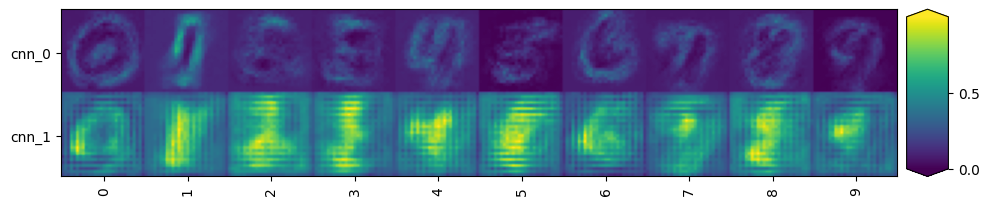

In [33]:
rel_model_name = ['Gradcam++'] #Gradcam, Gradcam++, Saliency, Scorecam
layer_name = ['cnn_0','cnn_1']
relM_ = [None]*len(rel_model_name) #relM[m] -> number classes x input image resolution x number of layers
tmpr_ = [None]*len(rel_model_name)
for m in range(len(rel_model_name)):
    relM_[m],tmpr_[m] = attention_wide(model,rel_model_name[m],layer_name,X_train,y_train,
                                       norm_c=True,norm_max_min=True,plot_int=False,transpose=False)


Saliency class 0 layer 
Saliency class 1 layer 
Saliency class 2 layer 
Saliency class 3 layer 
Saliency class 4 layer 
Saliency class 5 layer 
Saliency class 6 layer 
Saliency class 7 layer 
Saliency class 8 layer 
Saliency class 9 layer 


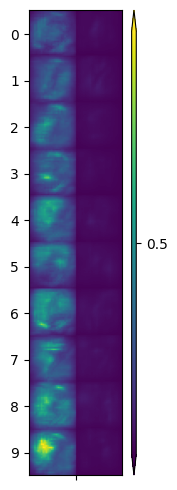

Gradcam++ class 0 layer wcnn_00
Gradcam++ class 0 layer wcnn_01
Gradcam++ class 0 layer wcnn_10
Gradcam++ class 0 layer wcnn_11
Gradcam++ class 0 layer wcnn_20
Gradcam++ class 0 layer wcnn_21
Gradcam++ class 1 layer wcnn_00
Gradcam++ class 1 layer wcnn_01
Gradcam++ class 1 layer wcnn_10
Gradcam++ class 1 layer wcnn_11
Gradcam++ class 1 layer wcnn_20
Gradcam++ class 1 layer wcnn_21
Gradcam++ class 2 layer wcnn_00
Gradcam++ class 2 layer wcnn_01
Gradcam++ class 2 layer wcnn_10
Gradcam++ class 2 layer wcnn_11
Gradcam++ class 2 layer wcnn_20
Gradcam++ class 2 layer wcnn_21
Gradcam++ class 3 layer wcnn_00
Gradcam++ class 3 layer wcnn_01
Gradcam++ class 3 layer wcnn_10
Gradcam++ class 3 layer wcnn_11
Gradcam++ class 3 layer wcnn_20
Gradcam++ class 3 layer wcnn_21
Gradcam++ class 4 layer wcnn_00
Gradcam++ class 4 layer wcnn_01
Gradcam++ class 4 layer wcnn_10
Gradcam++ class 4 layer wcnn_11
Gradcam++ class 4 layer wcnn_20
Gradcam++ class 4 layer wcnn_21
Gradcam++ class 5 layer wcnn_00
Gradcam+

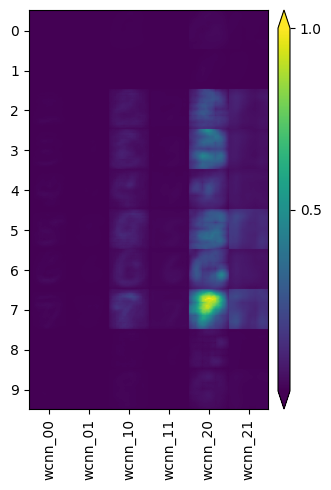

Scorecam class 0 layer wcnn_00


240/240 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
Scorecam class 0 layer wcnn_01
240/240 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Scorecam class 0 layer wcnn_10
479/479 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Scorecam class 0 layer wcnn_11
479/479 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Scorecam class 0 layer wcnn_20
479/479 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Scorecam class 0 layer wcnn_21
479/479 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Scorecam class 1 layer wcnn_00
282/282 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Scorecam class 1 layer wcnn_01
282/282 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Scorecam class 1 layer wcnn_10
563/563 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Scorecam class 1 layer wcnn_11
563/563 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Scorecam class 1 layer wcnn_20
563/563 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Scorecam class 1 layer wcnn_21
563/563 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Scorecam class 2 layer wcnn_00
244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Scorecam class 2 layer wcnn_01
244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Scorecam class 2 layer 

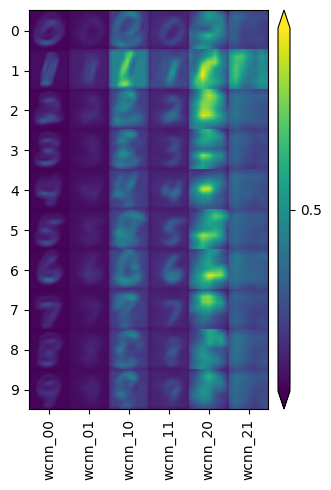

In [34]:
rel_model_name = ['Saliency','Gradcam++','Scorecam']#,'Scorecam','Saliency'] #Gradcam, Gradcam++, Saliency, Scorecam
layer_name = ['wcnn_00','wcnn_01','wcnn_10','wcnn_11','wcnn_20','wcnn_21']
relM_ = [None]*len(rel_model_name) #relM[m] -> number classes x input image resolution x number of layers
tmpr_ = [None]*len(rel_model_name) #relM[m] -> number classes x input image resolution x number of layers

for m in range(len(rel_model_name)):
    relM_[m],tmpr_[m] = attention_wide(model_dw,rel_model_name[m],layer_name,inputs_train,y_train,
                                     norm_c=False,norm_max_min=False,plot_int=False,transpose=True)
